# Womens Classifier Analysis

# Imports

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder

# Functions

In [32]:
def check_class_imbalance(target, type=None):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10,7))
  plt.title("Target Class Breakdown")
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Classes")
  plt.ylabel("Frequency")
  plt.xticks(rotation=45)
  plt.show()

def check_nulls_dupes(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of Dupe: {df.duplicated().sum()}")

# EDA Analysis

In [9]:
df = pd.read_csv("/Users/maukanmir/Downloads/ecommerce.csv", delimiter=';')
df

,Unnamed: 0,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
0,1,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,2,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,3,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,4,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,5,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23482,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23483,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23484,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23485,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


# Drop Useless Columns

In [10]:
df.drop(["Unnamed: 0", "Clothing.ID"], axis=1, inplace=True)

# Check For Nulls and Dupes

In [13]:
check_nulls_dupes(df)

The amount of Nulls: Age                           0
Title                      3810
Review.Text                 845
Rating                        0
Recommended.IND               0
Positive.Feedback.Count       0
Division.Name                14
Department.Name              14
Class.Name                   14
dtype: int64
The amount of Dupe: 232


In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.shape

(23254, 9)

# Check Class Imbalance

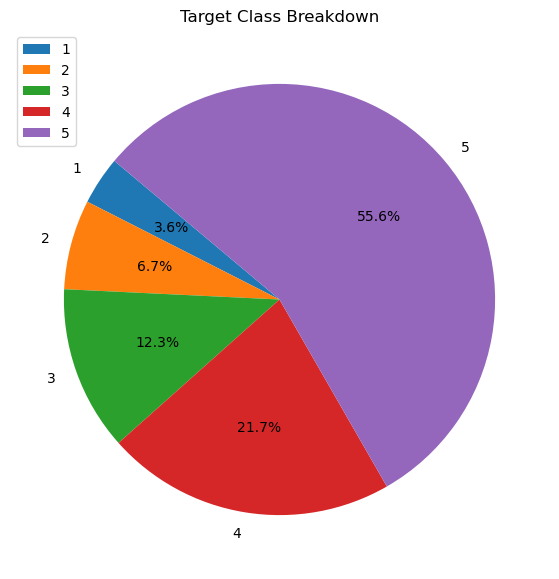

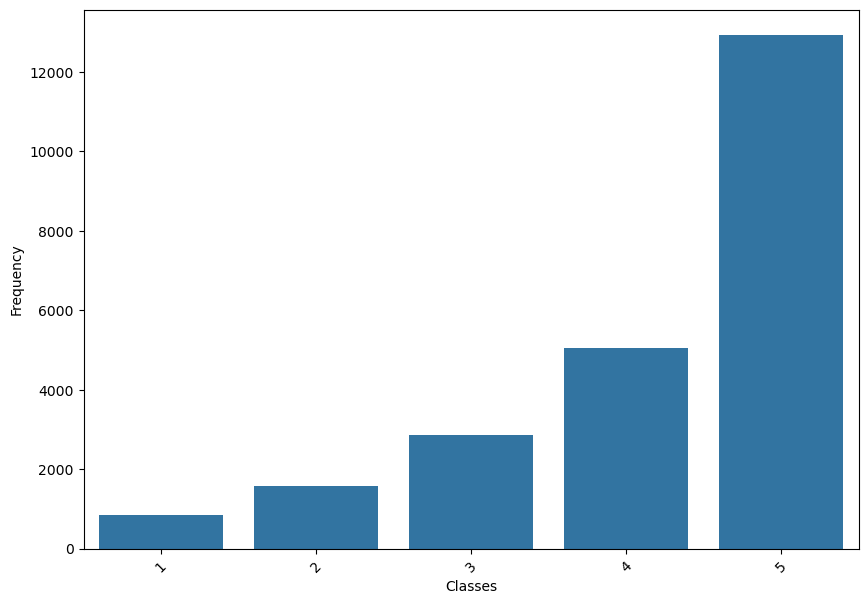

In [21]:
check_class_imbalance(df["Rating"])

# Class Imbalance Exists

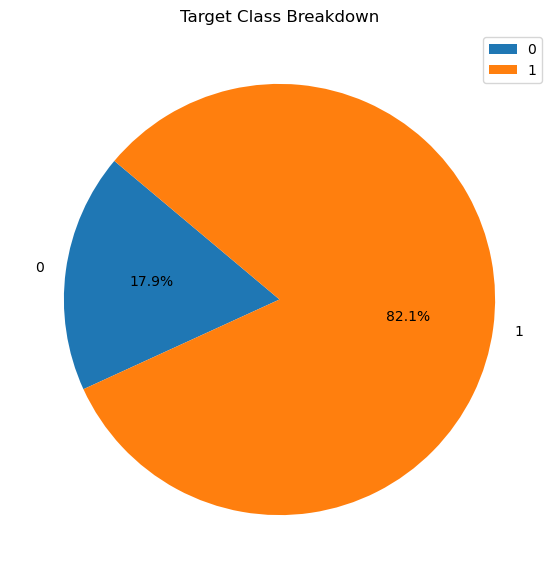

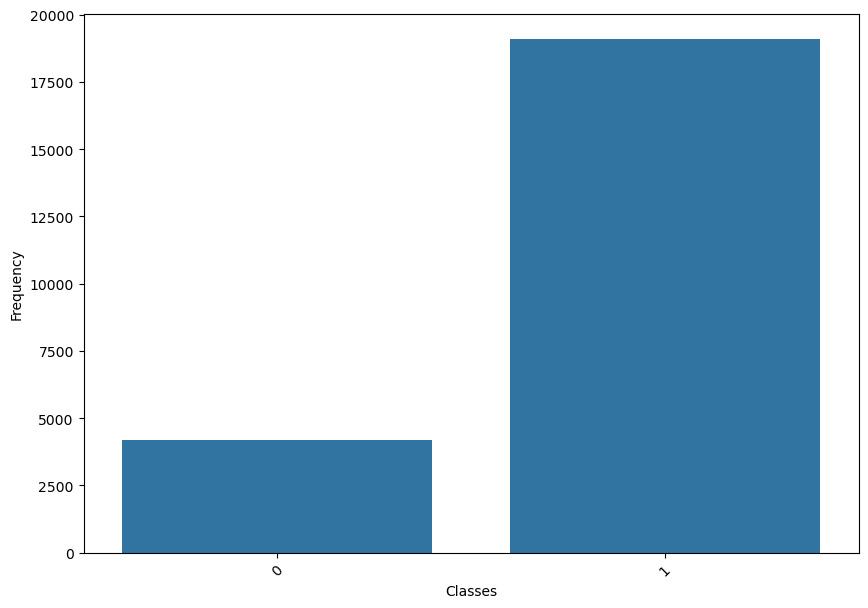

In [24]:
check_class_imbalance(df["Recommended.IND"])

# 80% of the customers either recommend the clothing. 

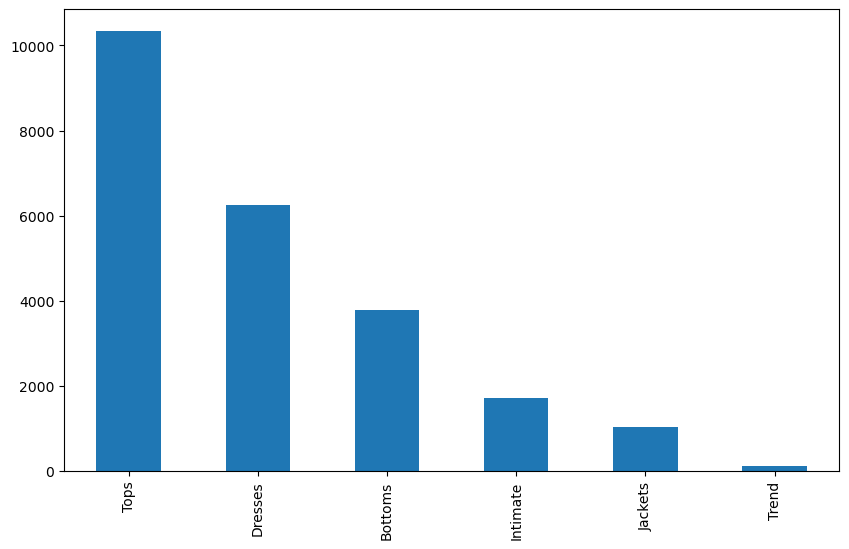

In [35]:
plt.figure(figsize=(10, 6))
df["Department.Name"].value_counts().plot.bar(x="Classes", y="Counts")
plt.show()

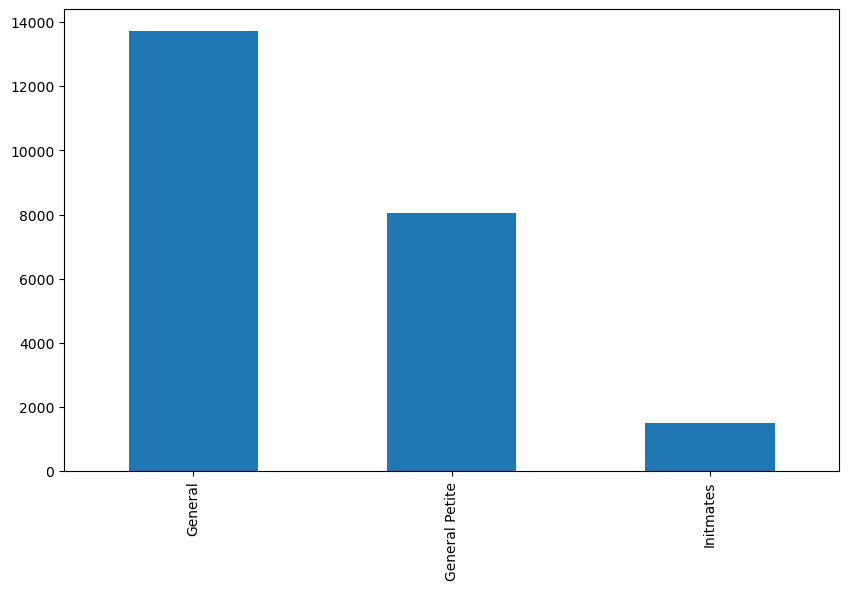

In [36]:
plt.figure(figsize=(10, 6))
df["Division.Name"].value_counts().plot.bar(x="Classes", y="Counts")
plt.show()

In [38]:
df.describe()

,Age,Rating,Recommended.IND,Positive.Feedback.Count
count,23254.000000,23254.000000,23254.000000,23254.000000
mean,43.234497,4.189258,0.820590,2.561237
std,12.308968,1.112980,0.383704,5.724920
min,18.000000,1.000000,0.000000,0.000000
25%,34.000000,4.000000,1.000000,0.000000
50%,41.000000,5.000000,1.000000,1.000000
75%,52.000000,5.000000,1.000000,3.000000
max,99.000000,5.000000,1.000000,122.000000


In [39]:
df.dtypes

Age                         int64
Title                      object
Review.Text                object
Rating                      int64
Recommended.IND             int64
Positive.Feedback.Count     int64
Division.Name              object
Department.Name            object
Class.Name                 object
dtype: object

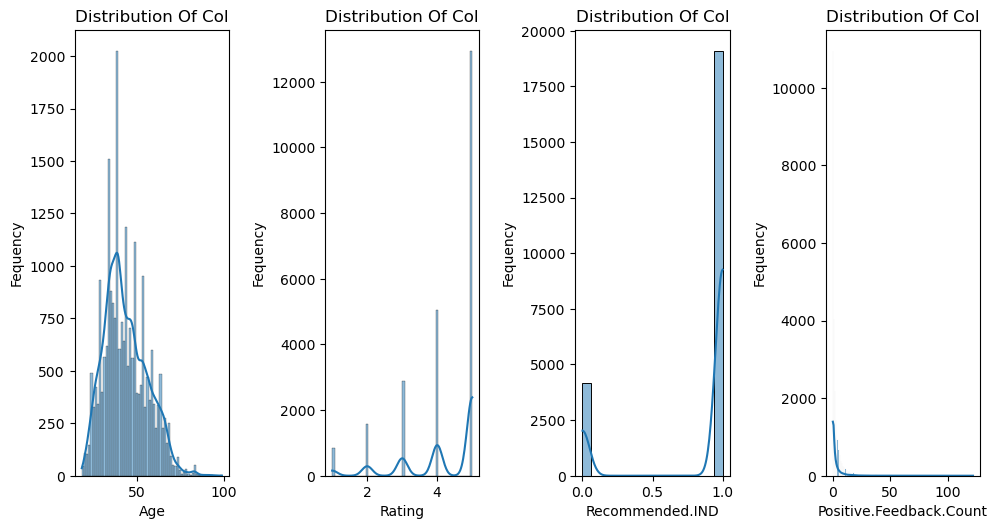

In [41]:
numerical_features = df.select_dtypes(include="int64")

plt.figure(figsize=(10, 10))
rows = len(numerical_features.columns)
dims = (rows +4)//3

for idx, col in enumerate(numerical_features.columns):
  plt.subplot(dims, 4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution Of {col}")
  plt.xlabel(col)
  plt.ylabel("Fequency")

plt.tight_layout()
plt.show()